In [77]:
import numpy as np
class Kalman_filter(object):
    def __init__(self, 
                 order=4,
                 time=0.01
                ):
        self.order = order
        self.time = time
        self.F = self.transitionMatrix(time)
        self.X = self.stateMatrix()
        self.B = self.controlMatrix(time)
        self.U = self.controlVector()
        self.P = self.stateVarMatrix()
        self.R = self.measureNoiseCovMatrix(time)
        self.Q = self.processNoiseCovMatrix(time)
        self.H = self.measurementMatrix()
        self.I = self.identityMatrix()
        
        self.FT= self.T(self.F)
        self.HT= self.T(self.H)
        
    # kalman_filter matrix setup
    def transitionMatrix(self, time=0):
        return np.array([[1, 0, time, 0],[0, 1, 0, time],[0, 0, 1, 0],[0, 0, 0, 1],])
    def stateMatrix(self):
        return np.zeros((self.order,1))
    def controlMatrix(self, time=0):
        t_ = (time**2)/2
        return np.array([[t_, 0],[0, t_],[time, 0],[0, time]])
    def controlVector(self, ax=0, ay=0):
        return np.array([[ax], [ay]])
    def stateVarMatrix(self):
    	return np.eye(self.order) * 1000
    def measureNoiseCovMatrix(self, time=0):
        R = np.eye(int(self.order/2))
        return R * time if time != 0 else R
    def processNoiseCovMatrix(self, time=0):
        Q = np.eye(self.order)
        return Q * time if time != 0 else Q
    def measurementMatrix(self):
        return np.array([[1, 0, 0, 0],[0, 1, 0, 0]])
    def identityMatrix(self):
        return np.eye(self.order)
    
    # calculation of array
    def dot(self, p, *args):
        for arg in args:
            p = np.dot(p, arg)
        return p
    def T(self, array):
        return array.transpose()
    def inverse(self, array):
        return np.linalg.inv(array)
    
    #setter, getter
    def set_state(self, state):
        self.X = state
    def set_varMatrix(self, covMatrix):
        self.P = covMatrix
    def get_state(self):
        return self.X
    def get_varMatrix(self):
        return self.P
    
    # kalman process:
    def predict(self):
        self.X = self.get_state()
        self.P = self.get_varMatrix()
        self.X = self.dot(self.F, self.X) + self.dot(self.B, self.U)
        self.P = self.dot(self.F, self.P, self.FT) + self.Q
        self.set_state(self.X)
        self.set_varMatrix(self.P)
        return self.X, self.P
    
    def update(self, measurement):
        self.X = self.get_state()
        self.P = self.get_varMatrix()
        A = self.dot(self.P, self.HT)
        B = self.inverse(self.dot(self.H, self.P, self.HT)+self.R)
        kalmanGain = self.dot(A, B)
        S = measurement.reshape((2,1)) - self.dot(self.H, self.X)
        self.X += self.dot(kalmanGain, S)
        self.P = self.dot((self.I - self.dot(kalmanGain, self.H)), self.P)
        self.set_state(self.X)
        self.set_varMatrix(self.P)
        return self.X, self.P

mean square error is 0.6866239945399374
variance reduced to 0.01 after 3 iteration
mean square error is 0.5971015599745939
variance reduced to 0.01 after 8 iteration
mean square error is 0.6537837387368426
variance reduced to 0.01 after 8 iteration


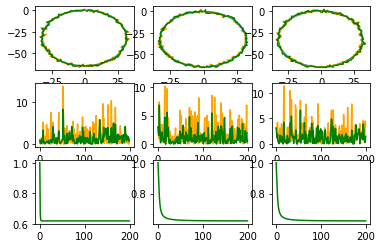

In [78]:
import matplotlib.pyplot as plt
import pickle
true = pickle.load(open("data2/true2.pickle","rb"))
tracka = pickle.load(open("data2/position2.pickle","rb"))
trackb = pickle.load(open("data2/velocity2.pickle","rb"))
trackc = pickle.load(open("data2/acceleration2.pickle","rb"))

measure = [tracka, trackb, trackc]
time = [0, 0.01, 0.01]
draw = 1
for index in range(len(measure)):
    Z = measure[index]
    t = time[index]
    
    kf = Kalman_filter(4, time=t)
    
    kalmanX, kalmanY = [], []
    error_obv, error_kal = [], []
    var_kal = []
    for i in range(len(Z)):
        if index == 2:
            ax = float(np.random.normal(0, 3, 1))
            ay = float(np.random.normal(0, 3, 1))
            kf.U = kf.controlVector(ax, ay)
        
        x_predict, p_predict = kf.predict()
        X, P = kf.update(Z[i])

        error_obv.append( (true[i,0]-Z[i,0])**2+(true[i,1]-Z[i,1])**2)
        error_kal.append( (true[i,0]-X[0,0])**2+(true[i,1]-X[1,0])**2)

        kalmanX.append(X[0,0])
        kalmanY.append(X[1,0])

        var_kal.append(P[0,0])

    plt.subplot(3,3,draw)
    print(f"mean square error is {(sum(error_kal)/len(error_kal)) / (sum(error_obv)/len(error_obv))}")
    plt.plot(true[:,0],true[:,1])
    plt.plot(Z[:,0],Z[:,1],c='orange')
    plt.plot(kalmanX, kalmanY, c='g')

    plt.subplot(3,3,3+draw)
    plt.plot(range(len(error_obv)), error_obv, c='orange')
    plt.plot(range(len(error_kal)), error_kal, c='g')

    var_kal = np.array(var_kal) * (1 / max(var_kal))
    stop = 1e-2
    first = var_kal[0]
    for i, v in enumerate(var_kal):
        if i == 0: continue
        if (first - v) < stop:
            print(f'variance reduced to {stop} after {i} iteration')
            break
        first = v
        
    plt.subplot(3,3,6+draw)
    plt.plot(range(len(var_kal)), var_kal, c='g')
    draw += 1
    
plt.show()
